##### preprocessing data

In [56]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("ResumeDataset.csv")  # Ganti dengan path dataset

# Contoh data
print(df.head())

# Cleaning text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter khusus
    text = text.lower()  # Konversi ke lowercase
    # Hapus stopwords dan lemmatisasi
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['Cleaned_Resume'] = df['Resume'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...


##### Tokenisasi dan Padding

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Cleaned_Resume'])
X = tokenizer.texts_to_sequences(df['Cleaned_Resume'])
X = pad_sequences(X, maxlen=200)  # Padding ke panjang 200

# Konversi label ke numerik
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

##### Membangun Model LSTM

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')
])

# Paksa build model dengan dummy input
import numpy as np
dummy_input = np.zeros((1, 200))
model.predict(dummy_input)

# Cetak summary
model.summary()

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (1, 200, 128)          │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (1, 200, 256)          │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (1, 128)               │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (1, 25)                │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,401 (4.11 MB)

 Trainable params: 1,077,401 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

##### Training Model

In [59]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0966 - loss: 3.1860 - val_accuracy: 0.0881 - val_loss: 3.3085
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1697 - loss: 2.9122 - val_accuracy: 0.3057 - val_loss: 2.4031
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3556 - loss: 2.2460 - val_accuracy: 0.5130 - val_loss: 1.6815
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5284 - loss: 1.5938 - val_accuracy: 0.6684 - val_loss: 1.2491
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6567 - loss: 1.1779 - val_accuracy: 0.8031 - val_loss: 0.7854
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7862 - loss: 0.7715 - val_accuracy: 0.8964 - val_loss: 0.5549
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8165 - loss: 0.6249 - val_accuracy: 0.9326 - val_loss: 0.3620
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8917 - loss: 0.4754 - val_accuracy: 0.9741 - val_loss:

##### Validasi Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step


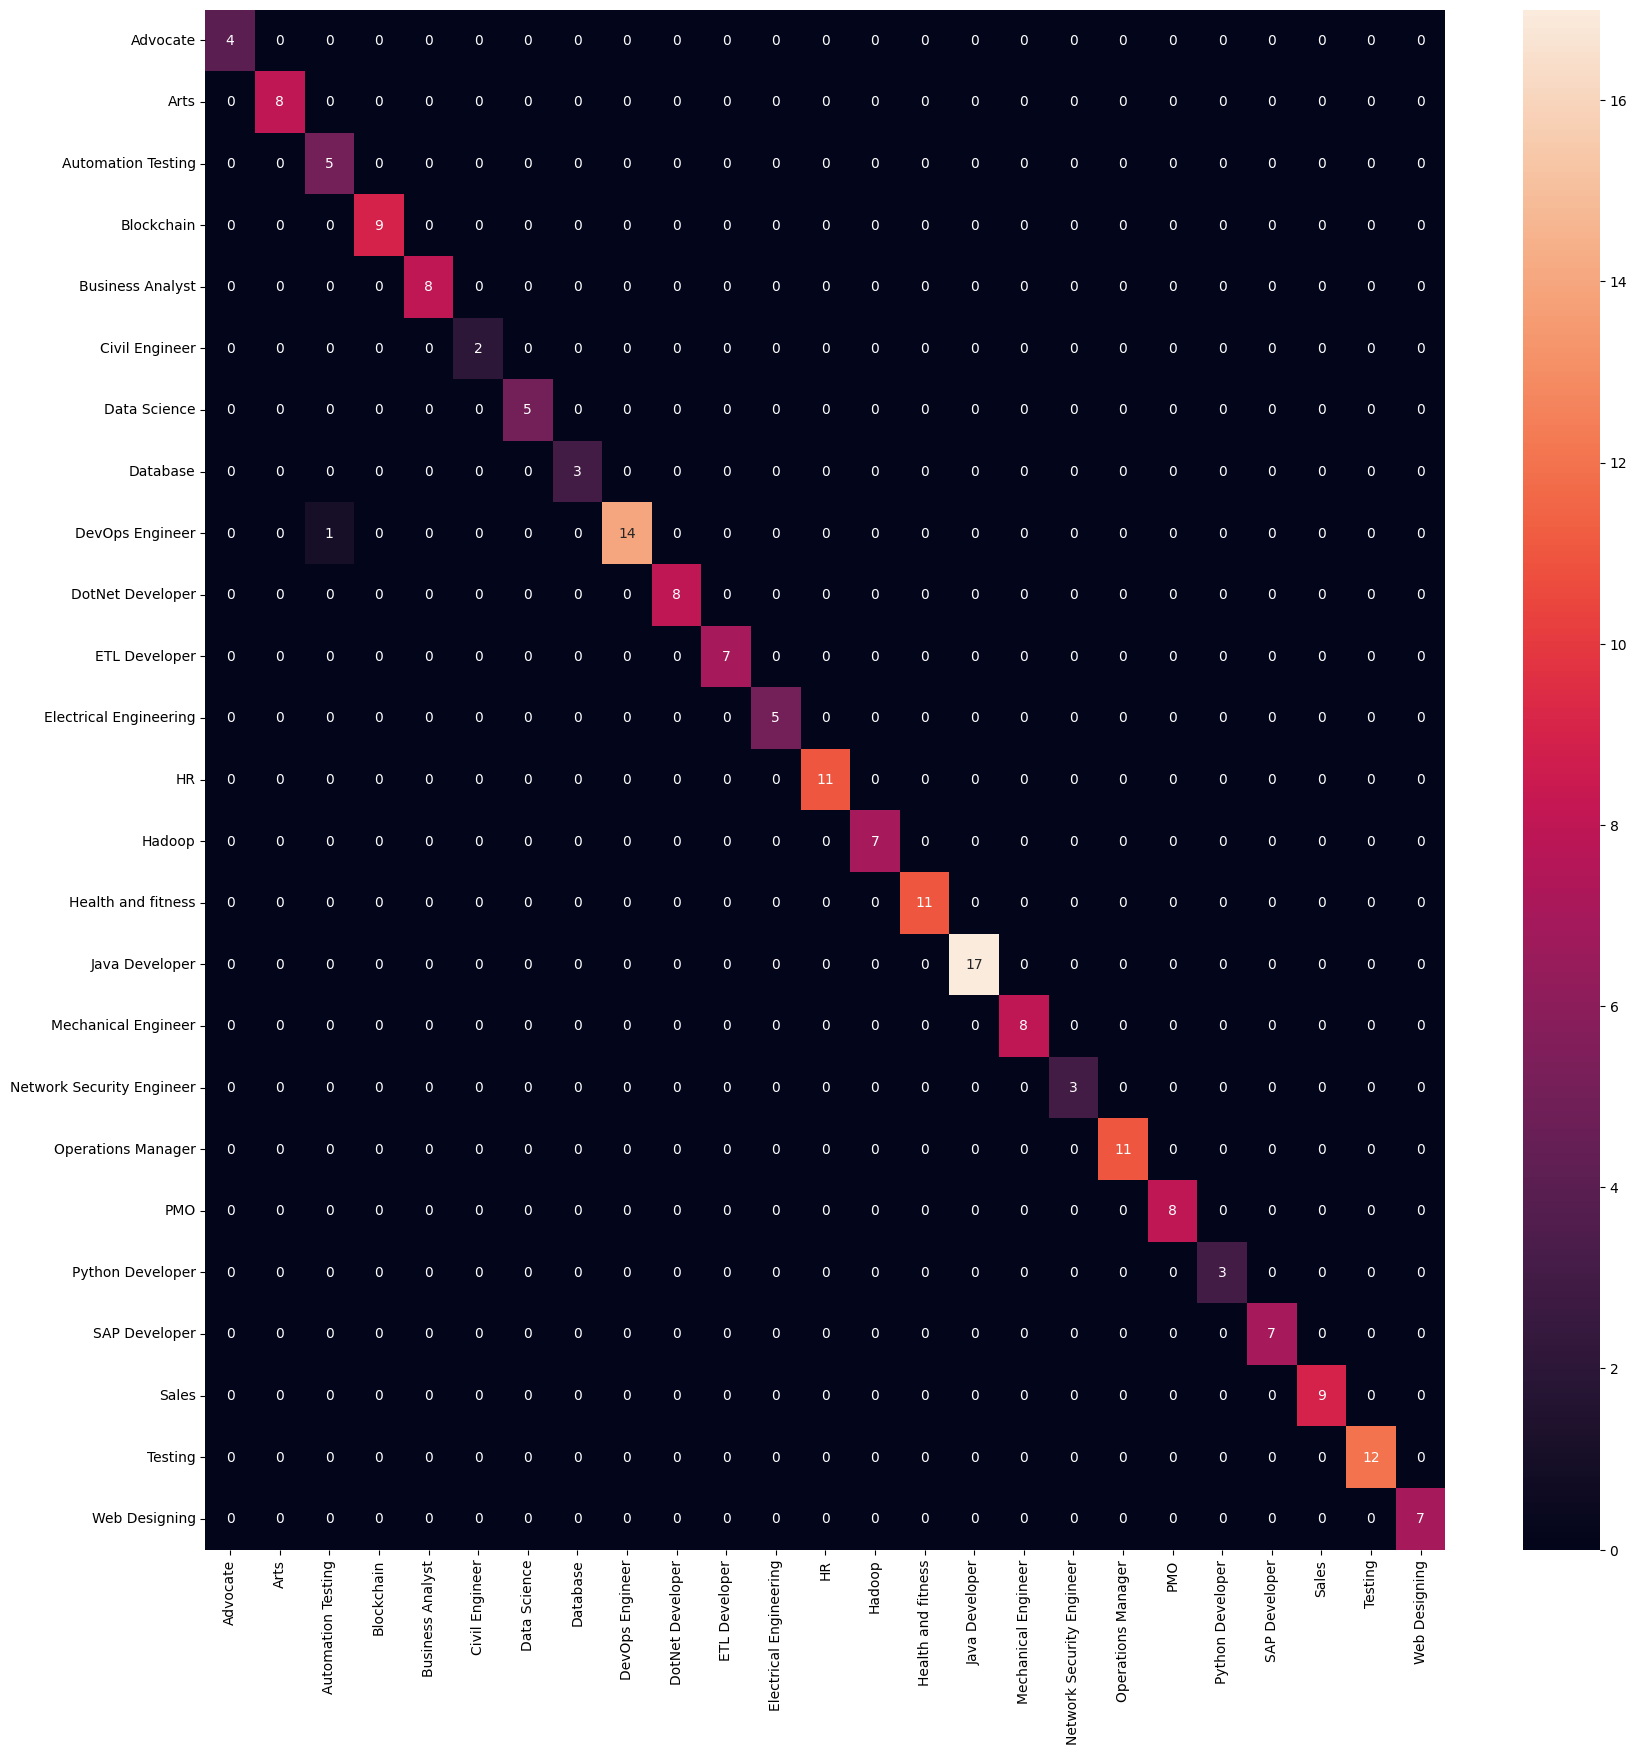

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.show()

In [62]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 1.0000 - loss: 0.0625
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.9950 - loss: 0.1303
Train Accuracy: 100.00% | Test Accuracy: 99.48%


##### Evaluasi & Prediksi

In [63]:
# Evaluasi
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

# Prediksi contoh
sample_resume = ["flask backend developer with ml pipeline experience"]
cleaned_sample = clean_text(sample_resume[0])
seq_sample = tokenizer.texts_to_sequences([cleaned_sample])
padded_sample = pad_sequences(seq_sample, maxlen=200)
prediction = model.predict(padded_sample)
predicted_prob = prediction.max() * 100
predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]

print(f"Predicted Category: {predicted_label} (Confidence: {predicted_prob:.2f}%)")
print("Top 3 Predictions:")
for i in range(3):
    print(f"- {label_encoder.inverse_transform([i])[0]}: {prediction[0][i]*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.9950 - loss: 0.1303
Accuracy: 99.48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted Category: HR (Confidence: 93.91%)
Top 3 Predictions:
- Advocate: 0.04%
- Arts: 0.01%
- Automation Testing: 0.01%


##### Menyimpan Model untuk Deployment

In [ ]:
model.save("resume_screening_lstm.h5")
import pickle

# Simpan tokenizer dan label encoder
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

## Siamese Neural Network

In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import numpy as np

# Load CSV
df = pd.read_csv("ResumeDataset.csv")  # kolom: 'category', 'resume'

# Encode category
le = LabelEncoder()
df['category_id'] = le.fit_transform(df['Category'])

# Bersihkan teks
import re
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text.lower()

df['resume'] = df['Resume'].apply(clean_text)

In [65]:
pairs = []
labels = []

category_groups = df.groupby('category_id')

for category_id, group in category_groups:
    resumes = group['resume'].values
    # Positif pair (sama category)
    for i in range(len(resumes) - 1):
        pairs.append([resumes[i], resumes[i + 1]])
        labels.append(1)

    # Negatif pair (beda category)
    other = df[df['category_id'] != category_id].sample(len(resumes))
    for i in range(len(resumes)):
        pairs.append([resumes[i], other['resume'].iloc[i]])
        labels.append(0)

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['resume'])

max_len = 200
X1 = tokenizer.texts_to_sequences([p[0] for p in pairs])
X2 = tokenizer.texts_to_sequences([p[1] for p in pairs])
X1 = pad_sequences(X1, maxlen=max_len)
X2 = pad_sequences(X2, maxlen=max_len)
y = np.array(labels)

# Split
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [67]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def build_siamese_model():
    input = Input(shape=(max_len,))
    x = Embedding(input_dim=5000, output_dim=128)(input)
    x = LSTM(64)(x)
    return Model(input, x)

base_network = build_siamese_model()

input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Distance function
def manhattan_distance(vects):
    x, y = vects
    return K.exp(-K.sum(K.abs(x - y), axis=1, keepdims=True))

distance = Lambda(manhattan_distance)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, 64)        │    689,408 │ input_layer_15[0… │
│ (Functional)        │                   │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ functional_11[0]… │
│                     │                   │            │ functional_11[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 689,408 (2.63 MB)

 Trainable params: 689,408 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 311ms/step - accuracy: 0.6467 - loss: 0.6336 - val_accuracy: 0.8079 - val_loss: 0.4619
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.9013 - loss: 0.3671 - val_accuracy: 0.8895 - val_loss: 0.3345
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.9602 - loss: 0.2663 - val_accuracy: 0.9447 - val_loss: 0.2653
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.9843 - loss: 0.2097 - val_accuracy: 0.9474 - val_loss: 0.2281
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.9885 - loss: 0.1813 - val_accuracy: 0.9711 - val_loss: 0.2281
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.9879 - loss: 0.1787 - val_accuracy: 0.9816 - val_loss: 0.2163
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.9913 - loss: 0.1628 - val_accuracy: 0.9895 - val_loss: 0.1846
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.9967 - loss: 0.1516 - val_accu

In [69]:
# Evaluasi
loss, acc = model.evaluate([X1_val, X2_val], y_val)
print(f"Validation Accuracy: {acc:.2f}")

# Prediksi kemiripan resume baru dengan resume python developer
query = "flask backend developer with ml pipeline experience"
query_clean = clean_text(query)
query_seq = pad_sequences(tokenizer.texts_to_sequences([query_clean]), maxlen=max_len)

# Bandingkan ke semua resume kategori "Python Developer"
python_resumes = df[df['Category'] == 'Python Developer']['Resume'].apply(lambda x: pad_sequences(tokenizer.texts_to_sequences([x]), maxlen=max_len)[0])
similarities = []

for resume_seq in python_resumes:
    score = model.predict([query_seq, np.array([resume_seq])], verbose=0)
    similarities.append(score[0][0])

print(f"Max Similarity to Python Developer Resumes: {max(similarities):.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9896 - loss: 0.1475
Validation Accuracy: 0.99
Max Similarity to Python Developer Resumes: 0.11
